In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine,text

In [7]:
user="root"
password="predestination"
host="localhost"
port=3306
database="superstore"

#connect to mysql using sqlalchemy
engine=create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}")

#test the connection
with engine.connect() as conn:
    result= conn.execute(text("SHOW TABLES;"))
    print("Tables in database:", [row[0] for row in result])

Tables in database: ['customers', 'products', 'sales']


In [8]:
#Load full sales data joined with customers & products

query="""
select 
c.customer_id, c.name, c.segment, c.country, c.city, c.state, c.postal_code, c.region, p.product_id, p.category, p.sub_category,
p.product_name, s.sale_id, s.order_id, s.customer_id, s.product_id, s.order_date, s.order_date_clean, s.ship_date, s.ship_mode, s.sales, s.quantity,
s.discount, s.profit
from sales s
join customers c on s.customer_id=c.customer_id
join products p on s.product_id=p.product_id;
"""


df=pd.read_sql(query,engine)
pd.set_option('display.max.columns',27)
df2=df.copy()
df2

,customer_id,name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sale_id,order_id,customer_id,product_id,order_date,order_date_clean,ship_date,ship_mode,sales,quantity,discount,profit
0,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,Furniture_Chairs_Hon Deluxe Fabric Upholstered...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",CA-2016-152156_1,CA-2016-152156,CG-12520,Furniture_Chairs_Hon Deluxe Fabric Upholstered...,11-08-2016,2016-08-11,11-11-2016,Second Class,731.9400,3,0.00,219.5820
1,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,Furniture_Bookcases_Bush Somerset Collection B...,Furniture,Bookcases,Bush Somerset Collection Bookcase,CA-2016-152156_0,CA-2016-152156,CG-12520,Furniture_Bookcases_Bush Somerset Collection B...,11-08-2016,2016-08-11,11-11-2016,Second Class,261.9600,2,0.00,41.9136
2,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,Office Supplies_Labels_Self-Adhesive Address L...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,CA-2016-138688_2,CA-2016-138688,DV-13045,Office Supplies_Labels_Self-Adhesive Address L...,06-12-2016,2016-12-06,6/16/2016,Second Class,14.6200,2,0.00,6.8714
3,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies_Storage_Eldon Fold 'N Roll Car...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,US-2015-108966_4,US-2015-108966,SO-20335,Office Supplies_Storage_Eldon Fold 'N Roll Car...,10-11-2015,2015-11-10,10/18/2015,Standard Class,22.3680,2,0.20,2.5164
4,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture_Tables_Bretford CR4500 Series Slim R...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,US-2015-108966_3,US-2015-108966,SO-20335,Furniture_Tables_Bretford CR4500 Series Slim R...,10-11-2015,2015-11-10,10/18/2015,Standard Class,957.5775,5,0.45,-383.0310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71940,AT-10435,Alyssa Tate,Home Office,United States,Akron,Ohio,44312,East,Furniture_Tables_Bevis 36 x 72 Conference Tables,Furniture,Tables,Bevis 36 x 72 Conference Tables,CA-2017-102407_4291,CA-2017-102407,AT-10435,Furniture_Tables_Bevis 36 x 72 Conference Tables,12-09-2017,2017-09-12,12/13/2017,Second Class,896.3280,9,0.20,22.4082
71941,AT-10435,Alyssa Tate,Home Office,United States,Akron,Ohio,44312,East,Office Supplies_Art_Newell 314,Office Supplies,Art,Newell 314,CA-2017-102407_4290,CA-2017-102407,AT-10435,Office Supplies_Art_Newell 314,12-09-2017,2017-09-12,12/13/2017,Second Class,11.1600,2,0.00,2.7900
71942,AT-10435,Alyssa Tate,Home Office,United States,Akron,Ohio,44312,East,Furniture_Furnishings_DAX Value U-Channel Docu...,Furniture,Furnishings,"DAX Value U-Channel Document Frames, Easel Back",CA-2016-100468_1503,CA-2016-100468,AT-10435,Furniture_Furnishings_DAX Value U-Channel Docu...,11/24/2016,2016-11-24,12-01-2016,Standard Class,9.9400,2,0.00,3.0814
71943,AT-10435,Alyssa Tate,Home Office,United States,Akron,Ohio,44312,East,Technology_Phones_iKross Bluetooth Portable Ke...,Technology,Phones,iKross Bluetooth Portable Keyboard + Cell Phon...,CA-2016-100468_1502,CA-2016-100468,AT-10435,Technology_Phones_iKross Bluetooth Portable Ke...,11/24/2016,2016-11-24,12-01-2016,Standard Class,33.5200,2,0.20,3.3520


In [9]:
# Display settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)


In [23]:
# 🧹 Step 1: Clean & Prep (if needed)

# Convert dates
df2['ship_date'] = pd.to_datetime(df2['ship_date'], errors='coerce')
df2['order_date_clean'] = pd.to_datetime(df2['order_date_clean'], errors='coerce')


#Create month and year column

df2['month']=df2['order_date_clean'].dt.to_period('M')
df2['year']=df2['order_date_clean'].dt.year


In [39]:
# 🧠 Step 2: Outlier Detection (Z-Score Method)

z_scores = stats.zscore(df2[['sales', 'profit', 'discount']])
outliers = (abs(z_scores) > 3).any(axis=1)
df2['is_outlier'] = outliers
top_sales_outliers = df2[outliers].sort_values('sales', ascending=False).head(10)

In [32]:
monthly['month'] = monthly['month'].astype(str)
monthly['month'] = monthly['month'].dt.to_timestamp()


AttributeError: Can only use .dt accessor with datetimelike values

TypeError: Invalid object type at position 0

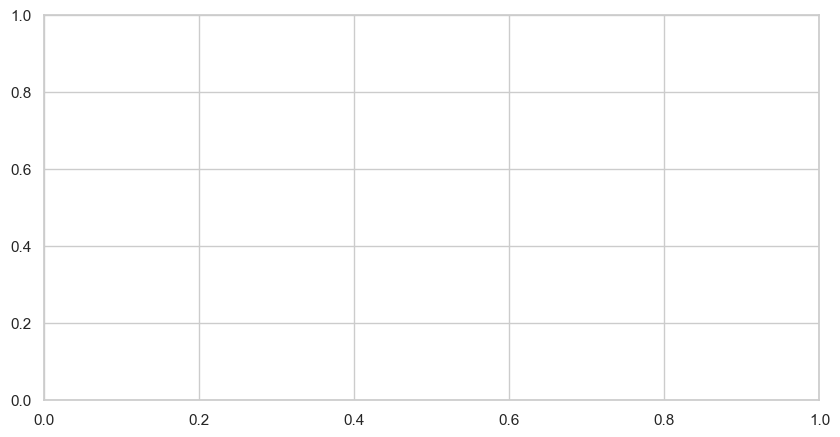

In [33]:
# 📈 Sales and Profit Over Time

monthly = df2.groupby('month').agg({'sales': 'sum', 'profit': 'sum'}).reset_index()
plt.figure()
sns.lineplot(data=monthly, x='month', y='sales', label='Sales')
sns.lineplot(data=monthly, x='month', y='profit', label='Profit')
plt.title("Monthly Sales & Profit Trend")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\acer\AppData\Local\Temp\ipykernel_24276\3949778856.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df2, x='category', y='profit', estimator=sum, ci=None)


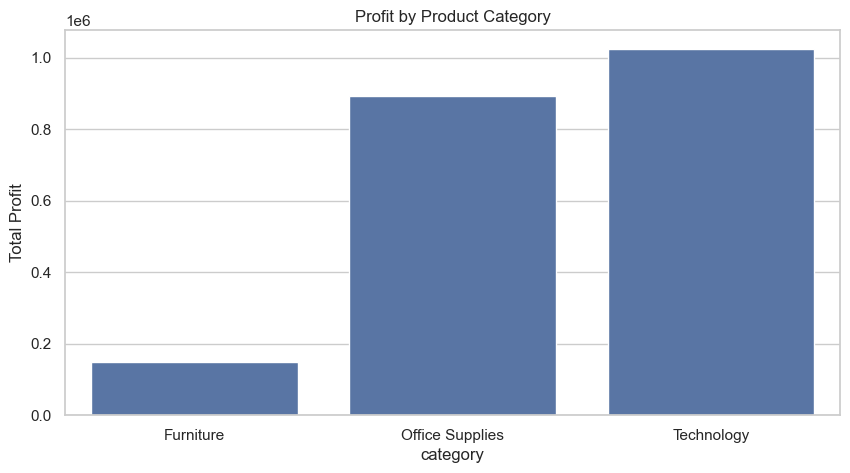

In [34]:
# 📦 Profit by Product Category

plt.figure()
sns.barplot(data=df2, x='category', y='profit', estimator=sum, ci=None)
plt.title("Profit by Product Category")
plt.ylabel("Total Profit")
plt.show()


C:\Users\acer\AppData\Local\Temp\ipykernel_24276\3271895949.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df2, x='region', y='profit', estimator=sum, ci=None)


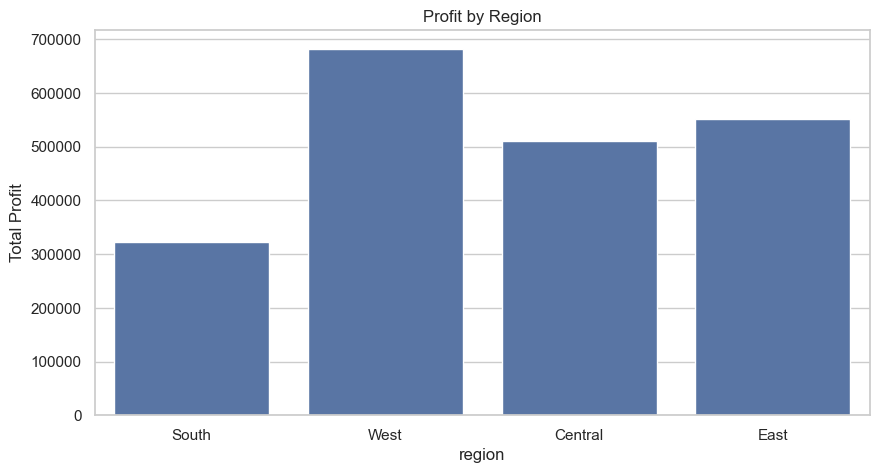

In [35]:
# 🌍 Profit by Region

plt.figure()
sns.barplot(data=df2, x='region', y='profit', estimator=sum, ci=None)
plt.title("Profit by Region")
plt.ylabel("Total Profit")
plt.show()


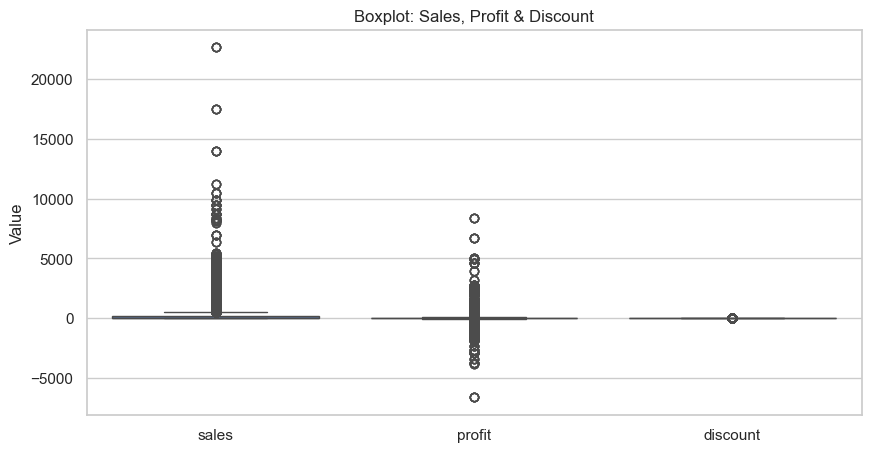

In [36]:
# 📊 Outlier Boxplots

plt.figure()
sns.boxplot(data=df2[['sales', 'profit', 'discount']])
plt.title("Boxplot: Sales, Profit & Discount")
plt.ylabel("Value")
plt.show()


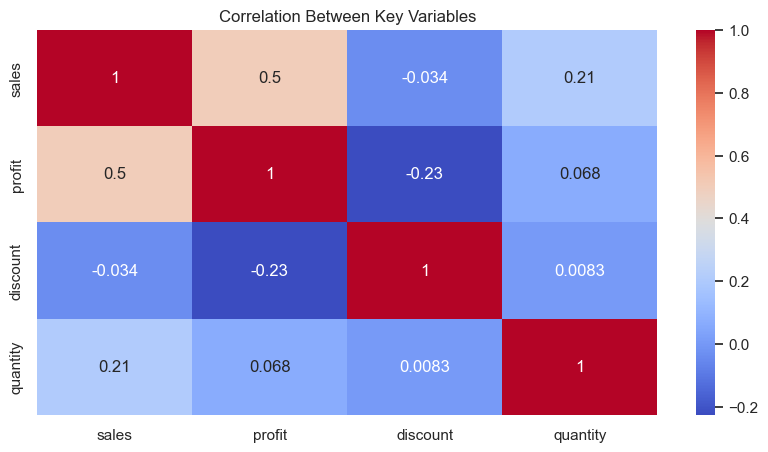

In [37]:
# 🔥 Correlation Heatmap

corr = df2[['sales', 'profit', 'discount', 'quantity']].corr()
plt.figure()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Key Variables")
plt.show()


In [38]:
# 🎯 Top Outlier Customers by Sales

plt.figure()
sns.barplot(data=top_sales_outliers, x='customer_id', y='sales', palette='viridis')
plt.title("Top 10 Outlier Customers by Sales")
plt.xticks(rotation=45)
plt.show()

ValueError: 2

<Figure size 1000x500 with 0 Axes>